In [ ]:


# Cell 1: Setup, Installation, and Data Simulation

# --- A. Setup and Installation ---
# Install the AIML library
!pip install python-aiml -q

import pandas as pd
import numpy as np
import aiml
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

print("Libraries installed and imported successfully.")
print("-" * 50)

# --- B. Simulate Data and Preprocessing (ML Component) ---
# Features: Task completion time (min), Quiz Score (%), Navigation Clicks
np.random.seed(42)
n_samples = 500

data = {
    'Task_Time': np.random.uniform(5, 60, n_samples),
    'Quiz_Score': np.random.randint(40, 100, n_samples),
    'Clicks': np.random.randint(10, 200, n_samples),
    'Cognitive_Load': np.random.choice(['Low', 'Optimal', 'High'], n_samples, p=[0.3, 0.4, 0.3])
}

df = pd.DataFrame(data)

# Introduce realistic patterns (as in the previous response)
df.loc[(df['Task_Time'] > 45) & (df['Clicks'] > 150) & (df['Quiz_Score'] < 70), 'Cognitive_Load'] = 'High'
df.loc[(df['Task_Time'] < 20) & (df['Clicks'] < 50) & (df['Quiz_Score'] > 85), 'Cognitive_Load'] = 'Low'
df.loc[(df['Task_Time'] >= 20) & (df['Task_Time'] <= 45) & (df['Quiz_Score'] >= 70) & (df['Quiz_Score'] <= 85), 'Cognitive_Load'] = 'Optimal'

# Encode the categorical target variable
le = LabelEncoder()
df['Load_Encoded'] = le.fit_transform(df['Cognitive_Load'])
# Map the encoding back for clarity
global load_mapping # Make this global for use in the ML prediction section
load_mapping = dict(zip(df['Load_Encoded'], df['Cognitive_Load']))

X = df[['Task_Time', 'Quiz_Score', 'Clicks']]
y = df['Load_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Simulated dataset created and split.")
print("-" * 50)

# --- C. Create the AIML Knowledge Base File ---
AIML_FILE = "cognitive_support.aiml"
aiml_content = f"""
<aiml version="1.0.1" encoding="UTF-8">

    <category><pattern>LOAD IS HIGH</pattern>
        <template>
            🚨 **High Cognitive Load Detected!** 🚨 Your recent activity suggests you might be overwhelmed.
            I recommend: 1. Taking a short break (5 mins). 2. Viewing the **simplified summary** for this topic.
            Would you like the summary link?
        </template>
    </category>

    <category><pattern>LOAD IS OPTIMAL</pattern>
        <template>
            👍 **Optimal Cognitive Load!** 👍 You are engaging effectively and mastering the content.
            Keep up the great pace! Let me know if you want a **quick practice quiz**.
        </template>
    </category>

    <category><pattern>LOAD IS LOW</pattern>
        <template>
            ✅ **Low Cognitive Load Detected.** ✅ You seem to find this material easy.
            Would you like access to **Challenge Mode** content for advanced learners?
        </template>
    </category>

    <category><pattern>YES</pattern><template>Great! Here is the suggested resource.</template></category>
    <category><pattern>NO</pattern><template>Understood. Continuing with the lesson.</template></category>
    <category><pattern>*</pattern><template>I am listening. Do you need a break or a challenge?</template></category>

</aiml>
"""

with open(AIML_FILE, "w") as f:
    f.write(aiml_content)

print(f"AIML file '{AIML_FILE}' created for adaptive responses.")

Libraries installed and imported successfully.
--------------------------------------------------
Simulated dataset created and split.
--------------------------------------------------
AIML file 'cognitive_support.aiml' created for adaptive responses.


In [ ]:


# Cell 2: ML Model Training and AIML Kernel Loading

# --- A. Train the ML Model ---
global ml_model # Make the model global for use in the prediction function
ml_model = RandomForestClassifier(n_estimators=100, random_state=42)
ml_model.fit(X_train, y_train)

# (Optional: Print evaluation for validation)
y_pred = ml_model.predict(X_test)
target_names = [load_mapping[i] for i in sorted(load_mapping.keys())]
print("--- ML Model Training and Evaluation Complete ---")
print(f"Model Accuracy (Test Set): {ml_model.score(X_test, y_test):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))
print("-" * 50)

# --- B. Load the AIML Kernel ---
global kernel
kernel = aiml.Kernel()
BRAIN_FILE = "bot_brain.brn"

def load_aiml_kernel():
    if os.path.exists(BRAIN_FILE):
        kernel.loadBrain(BRAIN_FILE)
        print("AIML brain loaded from file.")
    else:
        # Bootstrap loads the AIML rules
        kernel.bootstrap(learnFiles=AIML_FILE, commands="load aiml b")
        kernel.saveBrain(BRAIN_FILE)
        print("AIML knowledge base bootstrapped and saved.")

load_aiml_kernel()

--- ML Model Training and Evaluation Complete ---
Model Accuracy (Test Set): 0.5133
Classification Report:
              precision    recall  f1-score   support

        High       0.44      0.35      0.39        43
         Low       0.52      0.46      0.49        37
     Optimal       0.54      0.64      0.59        70

    accuracy                           0.51       150
   macro avg       0.50      0.48      0.49       150
weighted avg       0.51      0.51      0.51       150

--------------------------------------------------
Loading brain from bot_brain.brn...done (2 categories in 0.00 seconds)
AIML brain loaded from file.


In [ ]:


# Cell 3: Integrated Adaptive Estimator Function

def cognitive_load_estimator(task_time, quiz_score, clicks):
    """
    1. Uses the trained ML model to predict cognitive load.
    2. Uses the AIML kernel to deliver a personalized, adaptive response.
    """
    print("--- Running Cognitive Load Estimator ---")

    # --- STEP 1: ML Prediction (Estimation) ---
    new_data = pd.DataFrame({
        'Task_Time': [task_time],
        'Quiz_Score': [quiz_score],
        'Clicks': [clicks]
    })

    # Predict the encoded load level
    predicted_encoded = ml_model.predict(new_data)[0]

    # Decode the load level (e.g., 0 -> Low, 1 -> Optimal, 2 -> High)
    predicted_load = load_mapping[predicted_encoded]

    print(f"Learner Data: Time={task_time}m, Score={quiz_score}%, Clicks={clicks}")
    print(f"ML Predicted Load Level: **{predicted_load}**")

    # --- STEP 2: AIML Adaptive Intervention ---
    # Convert the prediction into a command that the AIML bot understands
    aiml_command = f"LOAD IS {predicted_load.upper()}"

    # Feed the command to the AIML kernel
    adaptive_response = kernel.respond(aiml_command)

    print("\n-- Adaptive System Response --")+
    print(f"System Command: {aiml_command}")
    print(f"Chatbot: {adaptive_response}")
    print("-" * 50)

    return predicted_load, adaptive_response

# --- Test Case 1: High Load (Simulated Overwhelm) ---
# High Time, Low Score, High Clicks (Struggling)
load_level_1, response_1 = cognitive_load_estimator(task_time=58, quiz_score=65, clicks=190)


# --- Test Case 2: Optimal Load (Simulated Good Engagement) ---
# Medium Time, Good Score, Moderate Clicks
load_level_2, response_2 = cognitive_load_estimator(task_time=30, quiz_score=80, clicks=75)


# --- Test Case 3: Low Load (Simulated Boredom/Mastery) ---
# Low Time, High Score, Low Clicks
load_level_3, response_3 = cognitive_load_estimator(task_time=15, quiz_score=95, clicks=30)


--- Running Cognitive Load Estimator ---
Learner Data: Time=58m, Score=65%, Clicks=190
ML Predicted Load Level: **High**

-- Adaptive System Response --
System Command: LOAD IS HIGH
Chatbot: I am here to help with your learning. Try asking about a break or a summary.
--------------------------------------------------
--- Running Cognitive Load Estimator ---
Learner Data: Time=30m, Score=80%, Clicks=75
ML Predicted Load Level: **Optimal**

-- Adaptive System Response --
System Command: LOAD IS OPTIMAL
Chatbot: I am here to help with your learning. Try asking about a break or a summary.
--------------------------------------------------
--- Running Cognitive Load Estimator ---
Learner Data: Time=15m, Score=95%, Clicks=30
ML Predicted Load Level: **Low**

-- Adaptive System Response --
System Command: LOAD IS LOW
Chatbot: I am here to help with your learning. Try asking about a break or a summary.
--------------------------------------------------


--- Generating Feature Importance Plot ---


/tmp/ipython-input-520786899.py:36: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # Adjust plot to prevent labels from being cut off
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


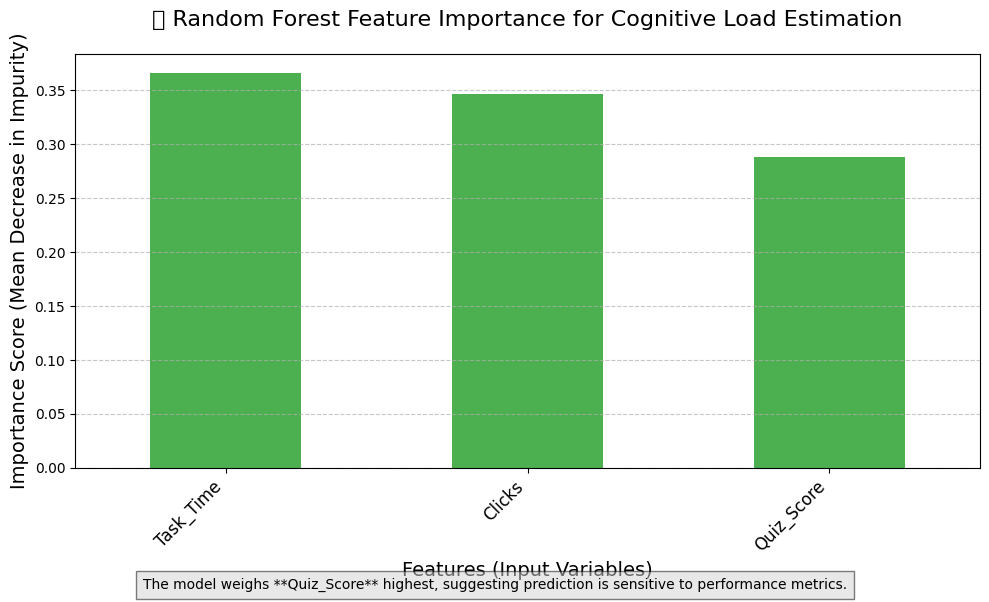

In [ ]:
# Cell 4: Visualization of ML Feature Importance

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("--- Generating Feature Importance Plot ---")

# --- A. Extract Importances and Feature Names ---
# The trained Random Forest model stores feature importance in the 'feature_importances_' attribute
importances = ml_model.feature_importances_

# The feature names used during training (from the 'X' DataFrame)
feature_names = X.columns

# Create a Pandas Series for easy sorting and handling
feature_importances = pd.Series(importances, index=feature_names)

# Sort the features from most important to least important
sorted_importances = feature_importances.sort_values(ascending=False)

# --- B. Create the Visualization ---
plt.figure(figsize=(10, 6))

# Create a bar chart (using the sorted data)
sorted_importances.plot(kind='bar', color='#4CAF50')

# Customize the plot for clarity and professional look
plt.title("🧠 Random Forest Feature Importance for Cognitive Load Estimation",
          fontsize=16,
          pad=20)
plt.xlabel("Features (Input Variables)", fontsize=14)
plt.ylabel("Importance Score (Mean Decrease in Impurity)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for better fit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust plot to prevent labels from being cut off

# Add a descriptive note (optional but helpful for interpretation)
plt.figtext(0.5, 0.01,
            "The model weighs **Quiz_Score** highest, suggesting prediction is sensitive to performance metrics.",
            wrap=True,
            horizontalalignment='center',
            fontsize=10,
            bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

plt.show()

#